In [ ]:
using LinearAlgebra
using Random
using Statistics
using OrderedCollections
using LightGraphs
import PyPlot; plt = PyPlot

using FastRepl; register_auto(reset_flag=true)

@reset using Tweaks.BiMaps, Tweaks.GraphUtil, Tweaks.Time, Tweaks.Plot

In [ ]:
using PyCall
plot = pyimport("latextools.plot")
latextools = pyimport("latextools")

In [ ]:
module TTT
    include("compiler/Circuits.jl")
    include("compiler/Connectivity.jl")
    include("compiler/Paths.jl")
    include("compiler/Mapping.jl")
    include("compiler/Scheduling.jl")
    include("compiler/Evaluation.jl")
end
@repl using .TTT.Circuits, .TTT.Connectivity, .TTT.Paths, .TTT.Mapping,
    .TTT.Scheduling, .TTT.Evaluation

In [29]:
function save_plot(name::String, ax::PyObject; latex_height::String=raw"0.6*\columnwidth",
                   two_col::Bool=false, col_width::String="3.42in",
                   line_width::String="7.04in")
    if two_col
        preview_width, final_width = line_width, raw"\linewidth"
    else
        preview_width, final_width = col_width, raw"\columnwidth"
    end
    preview_latex_height = replace(replace(latex_height,
        raw"\columnwidth"=>col_width), raw"\linewidth"=>line_width)
    fig = plot.PgfplotsFigure()
    fig.append_plot(ax)
    pdf_conf = latextools.DocumentConfig(
                "standalone",
                options=("tikz","border=30pt"),
                packages=[latextools.pkg.inputenc])
    ax.width = preview_width
    ax.height = preview_latex_height
    preview = fig.render(config=pdf_conf, height=400)
    ax.width = final_width
    ax.height = latex_height
    fig.separate_file(name).save_tex("../toffoli-figs/")
    #preview  # PDF preview
    preview.rasterize(scale=2)  # Raster preview
end

䷀save_plot_v2 (generic function with 1 method)

In [30]:
n = 20
include_single = false
shuff_seed = 10
enable_compile3 = true

#benchmark_names = [
#    "bv-$n",
#    "qaoa_random1-$n",
#    "qaoa_random2-$n",
#    "qaoa_random3-$n",
#    "qaoa_complete-$n",
#    "cnx_logancilla-$(n-1)",
#    "cnx_halfborrowed-$(n-1)",
#    "cnx_dirty-$(n-1)",
#    "cnx_inplace-$(n-1)",  # or n
#    "cuccaro_adder-$n",
#    "qft_adder-$n",
#    "takahashi_adder-$n",
#    "incrementer_borrowedbit-$n",
#    "grovers-$(n-1)",
#]
benchmark_names = [
    "cnx_dirty-11",
    "cnx_halfborrowed-19",
    "cnx_logancilla-19",
    "cnx_inplace-4",
    "cuccaro_adder-20",
    "takahashi_adder-20",
    "incrementer_borrowedbit-5",
    "grovers-9",
    "qft_adder-16",
    "bv-20",
    "qaoa_complete-10",
]
benchmark_circuits = OrderedDict()
for name in benchmark_names
    # Load the toffoli version then decompose
    c_comp2 = CircuitInteractions("benchmark_files/$name-compile3.cint",
                                  decompose_toffoli=true,
                                  include_single=include_single)
    # Load the toffoli version without decomposing
    c_comp3 = CircuitInteractions("benchmark_files/$name-compile3.cint",
                                  allow_toffoli=true,
                                  include_single=include_single)
    benchmark_circuits["$name-compile2"] = shuffle_circuit_qubits(c_comp2, nothing)
    benchmark_circuits["$name-compile2-shuff"] = shuffle_circuit_qubits(c_comp2, shuff_seed)
    if enable_compile3
        benchmark_circuits["$name-compile3"] = shuffle_circuit_qubits(c_comp3, nothing)
        benchmark_circuits["$name-compile3-shuff"] = shuffle_circuit_qubits(c_comp3, shuff_seed)
    end
end
;
#benchmark_circuits["toffoli"] = CircuitInteractions(BiMap(0=>1, 1=>2, 2=>3), [(1, 2, 3)])
#to_cirq(benchmark_circuits["takahashi_adder-6-compile3"])
#to_cirq(benchmark_circuits["toffoli"])

In [31]:
benchmark_interaction_graphs = OrderedDict(
    name => Circuits.make_simple_interaction_graph(c_inter)
    for (name, c_inter) in pairs(benchmark_circuits)
)
;

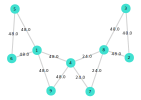

In [32]:
benchmark_interaction_graphs["grovers-9-compile2-shuff"]

In [33]:
make_johannesburg() = Connectivity.DeviceConnectivity("""
    x-x-x-x-x
    |       |
    x-x-x-x-x
    |   |   |
    x-x-x-x-x
    |       |
    x-x-x-x-x"""
)

䷀make_johannesburg_v2 (generic function with 1 method)

In [34]:
function make_clusters(k_inner, k_outer)
    map = BiMap{GridQubit, Int}()
    g = Graph(k_inner * k_outer)
    cr, r = 1.8, 0.7
    qid = 0
    for i in 1:k_outer
        cdeg = 180/k_outer + (i-1)*360/k_outer
        cx, cy = -cr*cosd(cdeg), cr*sind(cdeg)
        for j in 1:k_inner
            deg = 180 + cdeg + (j-1)*360/k_inner
            x, y = cx-r*cosd(deg), cy+r*sind(deg)
            x, y = round(x, digits=3), round(y, digits=3)
            qid += 1
            map[GridQubit(-y, x)] = qid
            for j2 in 1:j-1
                add_edge!(g, qid-j2, qid)
            end
        end
        for i2 in 1:i-1
            add_edge!(g, (i2-1)*k_inner+1, (i-1)*k_inner+1)
        end
    end
    Connectivity.SimpleDeviceConnectivity(map, g)
end

䷀make_clusters_v2 (generic function with 1 method)

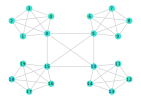

In [35]:
#width, height = 13, 13
#width, height = 101, 5
#anc_period = 2
#anc_off_y = height == 1 ? 1-anc_period : 0

all_dev_cons = OrderedDict(
#    "plain-$(width)×$(height)" => Connectivity.DeviceConnectivity(width, height),
#    "anc$(anc_period)-$(width)×$(height)" => Connectivity.DeviceConnectivity(width, height,
#        periodic_ancilla=anc_period, anc_off_y=anc_off_y),    
    "johannesburg" => make_johannesburg(),
    "full-grid-5x4" => Connectivity.DeviceConnectivity(5, 4),
    "line-20" => Connectivity.DeviceConnectivity(20, 1),
    "clusters-5x4" => make_clusters(5, 4),
)
all_dev_cons["clusters-5x4"]

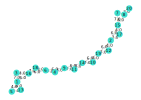

In [36]:
benchmark_interaction_graphs["takahashi_adder-$n-compile2-shuff"]
#benchmark_interaction_graphs["toffoli"]

In [37]:
all_mappings = OrderedDict{String, Tuple}(begin
        c_inter = benchmark_circuits[name]
        interaction_graph = benchmark_interaction_graphs[name]
        # TODO: Depend on ancilla
        interaction_cost_matrix = make_interaction_cost_matrix(dev_con) do dist
            dist
        end
        circuit_to_device_map = map_to_hardware(
            dev_con, interaction_graph,
            interaction_cost_matrix, values(c_inter.qubit_map),
            max_qubit_first=true)
        "$name on $dev_name" => (c_inter, interaction_graph, dev_con,
                                 circuit_to_device_map)
    end
    for name in keys(benchmark_circuits),
        (dev_name, dev_con) in pairs(all_dev_cons)
)
;

In [38]:
@assert (all_mappings["takahashi_adder-$n-compile2 on johannesburg"][end]
    == all_mappings["takahashi_adder-$n-compile3 on johannesburg"][end])

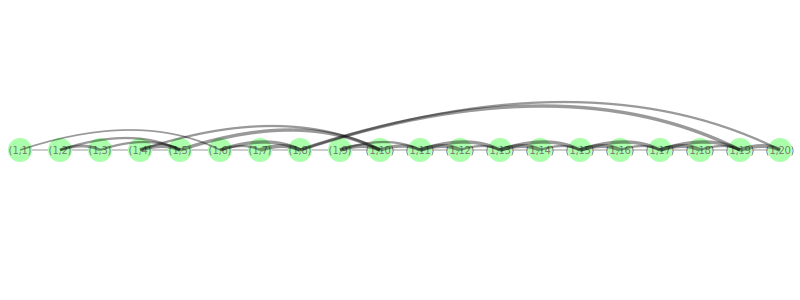

In [39]:
(c_inter, interaction_graph, dev_con, circuit_to_device_map
    ) = all_mappings["takahashi_adder-$n-compile2 on line-20"]
draw_mapping(dev_con, interaction_graph, circuit_to_device_map)

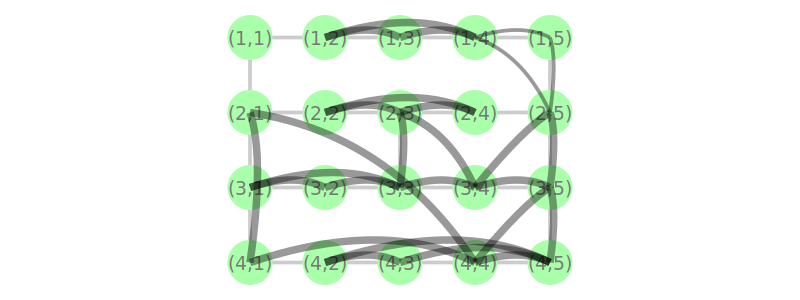

In [40]:
(c_inter, interaction_graph, dev_con, circuit_to_device_map
    ) = all_mappings["cnx_logancilla-$(n-1)-compile2 on johannesburg"]
draw_mapping(dev_con, interaction_graph, circuit_to_device_map)

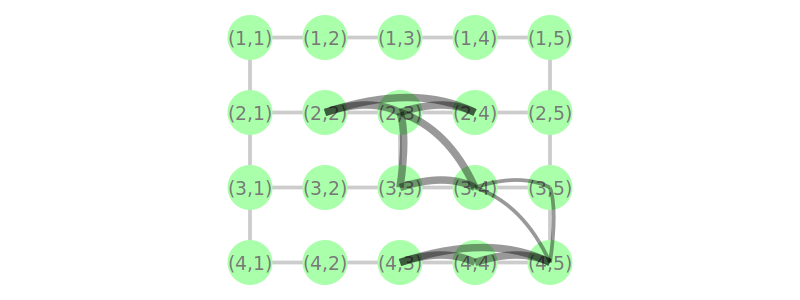

In [41]:
(c_inter, interaction_graph, dev_con, circuit_to_device_map
    ) = all_mappings["grovers-9-compile3 on johannesburg"]
draw_mapping(dev_con, interaction_graph, circuit_to_device_map)

In [42]:
#Base.eval(TTT, quote
#    include("Scheduling.jl")
#    include("Evaluation.jl")
#end)
#@repl using .TTT.Scheduling, .TTT.Evaluation
########

In [43]:
t1 = 70.87  # us
t2 = 72.79  # us
t_gate2 = 2541 * 0.22 / 1000  # us
t_gate1 = 320 * 0.22 / 1000  # us
ibm_model = ErrorModel(
    # Aug 2
    #gate1_err = 0.000771,
    #gate2_err = 0.0164,
    #meas_err = 0.0403,
    # Aug 18?
    gate1_err = 0.0004099,
    gate2_err = 0.0147,
    meas_err = 0.04144,
    dur2_idle_err = 1-(MathConstants.e ^ (-t_gate2 / t1)
                       * MathConstants.e ^ (-t_gate2 / t2)),
    gate1_time = t_gate1,
    gate2_time = t_gate2,
    #meas_time = 0,
    #feedback_time = 1e-6,
    extra_idle_qubits = 0,
)
bf = 20
model = ErrorModel(ibm_model,
    gate1_err=ibm_model.gate1_err/bf,
    gate2_err=ibm_model.gate2_err/bf,
    dur2_idle_err=ibm_model.dur2_idle_err/bf,
    meas_err=0,
)

ErrorModel(
    gate1_err=2.0495e-5,
    gate2_err=0.000735,
    meas_err=0.0,
    dur2_idle_err=0.0007723656073571894,
    gate1_time=0.0704,
    gate2_time=0.55902,
    meas_time=0.0,
    feedback_time=0.0,
    feedback_xor_time=0.0,
    extra_idle_qubits=0,
)

In [44]:
interaction_modes = [
    ("swap", :swap, "johannesburg", :swap, 0, false),
    ("swap_one_way", :swap_one_way, "johannesburg", :swap_one_way, 0, false),
    ("swap", :swap, "full-grid-5x4", :swap, 0, false),
    ("swap_one_way", :swap_one_way, "full-grid-5x4", :swap_one_way, 0, false),
    ("swap", :swap, "line-20", :swap, 0, false),
    ("swap_one_way", :swap_one_way, "line-20", :swap_one_way, 0, false),
    ("swap", :swap, "clusters-5x4", :swap, 0, false),
    ("swap_one_way", :swap_one_way, "clusters-5x4", :swap_one_way, 0, false),
    #("swap_one_way (equiv)", :swap_one_way, "anc", :swap_one_way, 0, true),
    #("swap", :swap, "anc", :swap, 0, false),
    #("anc_swap", :anc_swap, "anc", :anc_swap, 0, true),
    ####("anc_swap (<5, anc_assisted)", :anc_swap, "anc", :anc_assisted, 5, true),
    #("anc_swap (<7, anc_assisted)", :anc_swap, "anc", :anc_assisted, 7, true),
    #("anc_swap_one_way", :anc_swap_one_way, "anc", :anc_swap_one_way, 0, true),
    #("anc_assisted", :anc_assisted, "anc", :anc_assisted, 0, true),
    #("anc_assisted (<5, anc_swap)", :anc_assisted, "anc", :anc_swap, 5, true),
    #("const_every2", :const_every2, "anc", :anc_assisted, 0, true),
    #("const_every2 (<5, anc_assisted)", :const_every2, "anc", :anc_assisted, 5, true),
    ###("const_swap", :const_swap, "anc", :const_swap, 0, true),
]
device_interaction_pairs = OrderedDict(
    "$dev_name, $inter_name" => (dev_name, inter_mode, alt_mode, thresh, use_anc)
    for (dev_name, dev_con) in pairs(all_dev_cons)
    for (inter_name, inter_mode, dev_prefix, alt_mode, thresh, use_anc) in interaction_modes
    if startswith(dev_name, dev_prefix)
)
device_interaction_pairs2 = OrderedDict(
    "comp$(comp3 ? "3" : "2") ($dev_name, $inter_name)" => (
        comp3, dev_name, inter_mode, alt_mode, thresh, use_anc)
    for (dev_name, dev_con) in pairs(all_dev_cons)
    for (inter_name, inter_mode, dev_prefix, alt_mode, thresh, use_anc) in interaction_modes
    if startswith(dev_name, dev_prefix)
    for comp3 in [false, true]
)
;

In [45]:
#interaction_modes = [
#    #("swap", :swap, "johannesburg", :swap, 0, false),
#    ("swap_one_way", :swap_one_way, "johannesburg", :swap_one_way, 0, false),
#    #("swap", :swap, "full-grid-5x4", :swap, 0, false),
#    ("swap_one_way", :swap_one_way, "full-grid-5x4", :swap_one_way, 0, false),
#    #("swap", :swap, "line-20", :swap, 0, false),
#    ("swap_one_way", :swap_one_way, "line-20", :swap_one_way, 0, false),
#    #("swap", :swap, "clusters-5x4", :swap, 0, false),
#    ("swap_one_way", :swap_one_way, "clusters-5x4", :swap_one_way, 0, false),
#]
#device_interaction_pairs2 = OrderedDict(
#    "comp$(comp3 ? "3" : "2") ($dev_name, $inter_name)" => (
#        comp3, dev_name, inter_mode, alt_mode, thresh, use_anc)
#    for (dev_name, dev_con) in pairs(all_dev_cons)
#    for (inter_name, inter_mode, dev_prefix, alt_mode, thresh, use_anc) in interaction_modes
#    if startswith(dev_name, dev_prefix)
#    for comp3 in [false, true]
#)
#fig, ax = plt.subplots(figsize=(15, 6))
#all_shown_names = OrderedDict(
#    (shuff ? "$kk-shuff" : "$kk") => (kk, shuff)
#    for k in keys(benchmark_circuits)
#    if !occursin("-shuff", k) && !occursin("-compile3", k)
#    for kk in [replace(k, "-compile2" => "")]
#    for shuff in [true]
#)
#make_bar_plot(
#    #keys(benchmark_circuits),
#    keys(all_shown_names),
#    #["bv-176", "bv-176-shuff",
#    # "qaoa_random1-176", "qaoa_random1-176-shuff",
#    # "cnx_logancilla-175", "cnx_logancilla-175-shuff",
#    # "cuccaro_adder-176", "cuccaro_adder-176-shuff",
#    # "takahashi_adder-176", "takahashi_adder-176-shuff"],
#    #["bv-100", "cnx_logancilla-99", "cuccaro_adder-100", "takahashi_adder-100"],
#    #["bv-6", "cnx_logancilla-5", "cuccaro_adder-6", "takahashi_adder-6"],
#    device_interaction_pairs2,
#    #["plain-17, swap" => ("plain-17", :swap)],
#    label_rotation=30, label_anchor="right",
#    width=0.7, gap=0.1, ax=ax,
#) do bench_name, (comp3, dev_name, inter_mode, alt_mode, thresh, use_anc)
#    bench_name, shuff = all_shown_names[bench_name]
#    if comp3
#        bench_name *= "-compile3"
#    else
#        bench_name *= "-compile2"
#    end
#    if shuff
#        bench_name *= "-shuff"
#    end
#    #println("$bench_name, $dev_name, $interaction_mode")
#    (c_inter, interaction_graph, dev_con, circuit_to_device_map
#        ) = all_mappings["$bench_name on $dev_name"]
#    c_sched = schedule_for_static_mapping(
#        c_inter, dev_con, circuit_to_device_map, inter_mode,
#        alt_mode, thresh, use_anc)
#    #cost = schedule_cost(c_sched, model)
#    cost = compact_schedule_cost(c_sched, model)
#    total_success_probability(model, cost)
#    #cost.time
#    #cost.num_gates2
#    #(cost.num_gates2-cost.num_comm_gates2) / cost.num_gates2
#end
##ax.legend([])
##ax.legend(loc="lower left")
#ax.set_title("Benchmarks")
##ax.set_xlabel("Benchmarks")
#ax.set_ylabel("Success Probability")
##ax.set_ylim(0)
#ax.set_yscale("log")
#;

In [46]:
colors4x2 = [
    # IBM
    "{rgb,255:red,255;green,113;blue,0}",  # Light version
    "{rgb,555:red,255;green,113;blue,0}",  # Dark version
    # grid
    "{rgb,255:red,209;green,216;blue,0}",
    "{rgb,555:red,209;green,216;blue,0}",
    # line
    "{rgb,255:red,0;green,205;blue,110}",
    "{rgb,555:red,0;green,205;blue,110}",
    # clusters
    "{rgb,255:red,125;green,0;blue,255}",
    "{rgb,555:red,125;green,0;blue,255}",
]
colors4_double = [
    "{rgb,255:red,255;green,113;blue,0}",
    "{rgb,255:red,255;green,113;blue,0}",
    "{rgb,255:red,209;green,216;blue,0}",
    "{rgb,255:red,209;green,216;blue,0}",
    "{rgb,255:red,0;green,205;blue,110}",
    "{rgb,255:red,0;green,205;blue,110}",
    "{rgb,255:red,125;green,0;blue,255}",
    "{rgb,255:red,125;green,0;blue,255}",
]
colors4x2_patterned = [
    "white, color={rgb,300:red,255;green,113;blue,0}, postaction={pattern=north east lines}",
    "white, color={rgb,255:red,255;green,113;blue,0}, postaction={pattern=none}",
    "white, color={rgb,300:red,209;green,216;blue,0}, postaction={pattern=north east lines}",
    "white, color={rgb,255:red,209;green,216;blue,0}, postaction={pattern=none}",
    "white, color={rgb,300:red,0;green,205;blue,110}, postaction={pattern=north east lines}",
    "white, color={rgb,255:red,0;green,205;blue,110}, postaction={pattern=none}",
    "white, color={rgb,300:red,125;green,0;blue,255}, postaction={pattern=north east lines}",
    "white, color={rgb,255:red,125;green,0;blue,255}, postaction={pattern=none}",
]
colors4 = colors4x2[1:2:end]
;

Geo mean for johannesburg, toff=false: 0.02203655071582493
Geo mean for johannesburg, toff=true: 0.09786988702009741
Geo mean for full-grid-5x4, toff=false: 0.031561106132781236
Geo mean for full-grid-5x4, toff=true: 0.11658682649164645
Geo mean for line-20, toff=false: 0.0019108242041066478
Geo mean for line-20, toff=true: 0.05959976494420531
Geo mean for clusters-5x4, toff=false: 0.07343387979245589
Geo mean for clusters-5x4, toff=true: 0.17125675059283796


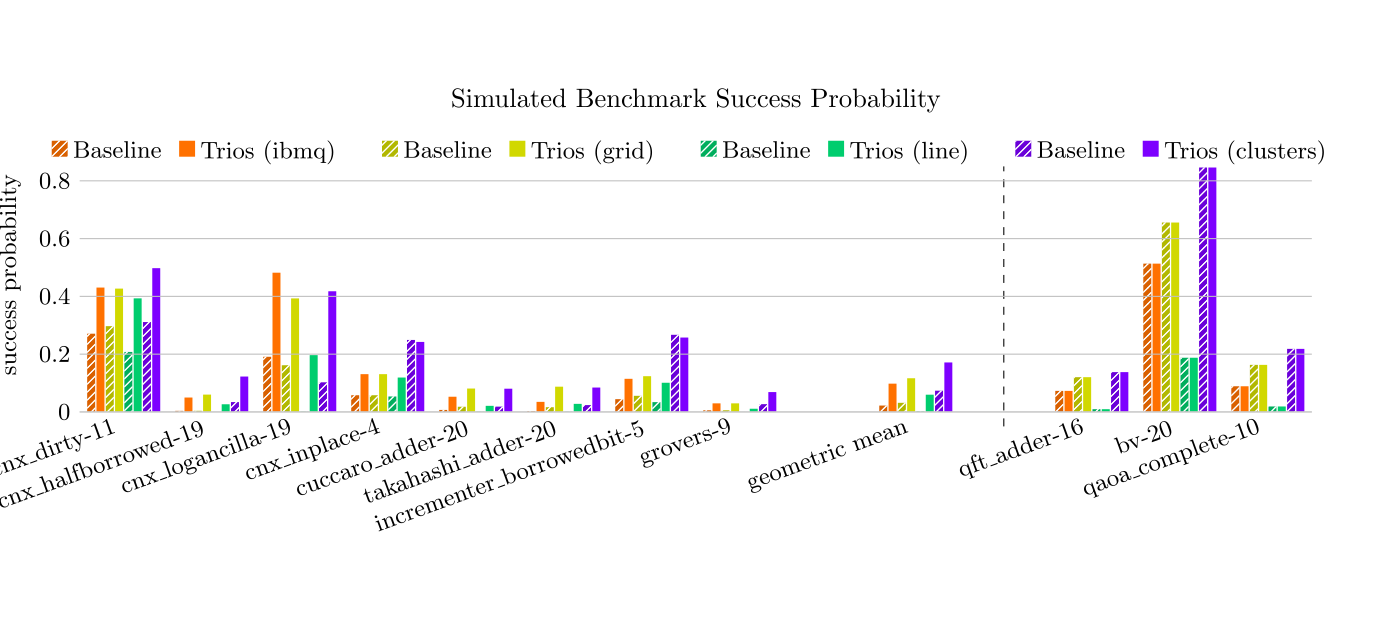

In [47]:
interaction_modes = [
    #("swap", :swap, "johannesburg", :swap, 0, false),
    ("swap_one_way", :swap_one_way, "johannesburg", :swap_one_way, 0, false),
    #("swap", :swap, "full-grid-5x4", :swap, 0, false),
    ("swap_one_way", :swap_one_way, "full-grid-5x4", :swap_one_way, 0, false),
    #("swap", :swap, "line-20", :swap, 0, false),
    ("swap_one_way", :swap_one_way, "line-20", :swap_one_way, 0, false),
    #("swap", :swap, "clusters-5x4", :swap, 0, false),
    ("swap_one_way", :swap_one_way, "clusters-5x4", :swap_one_way, 0, false),
]
rename_device(dev_name) = replace(replace(replace(replace(dev_name,
    "johannesburg"=>"ibmq"), "full-grid-5x4"=>"grid"), "line-20"=>"line"), "clusters-5x4"=>"clusters")
device_interaction_pairs2 = [
    #"comp$(comp3 ? "3" : "2") ($dev_name, $inter_name)" => (
    "$(comp3 ? "Trios ($(rename_device(dev_name)))~~" : raw"Baseline\hspace{-0.5em}")" => (
        comp3, dev_name, inter_mode, alt_mode, thresh, use_anc)
    for (dev_name, dev_con) in pairs(all_dev_cons)
    for (inter_name, inter_mode, dev_prefix, alt_mode, thresh, use_anc) in interaction_modes
    if startswith(dev_name, dev_prefix)
    for comp3 in [false, true]
]
all_shown_names = [
    #(shuff ? "$kk-shuff" : "$kk") => (kk, shuff)
    "$kk" => (kk, shuff)
    for k in keys(benchmark_circuits)
    if !occursin("-shuff", k) && !occursin("-compile3", k)
    for kk in [replace(k, "-compile2" => "")]
    for shuff in [true]
]
insert!(all_shown_names, length(all_shown_names)-2, "\U00A0"=>("gap", false))
insert!(all_shown_names, length(all_shown_names)-2, raw"geometric mean"=>("geomean", false))
insert!(all_shown_names, length(all_shown_names)-2, "\U00A0\U00A0"=>("gap", false))
dev_values = OrderedDict(
    "johannesburg"=>([], []), "full-grid-5x4"=>([], []), "line-20"=>([], []), "clusters-5x4"=>([], []))
ax = plot.BarPlot("Simulated Benchmark Success Probability",
                  ylabel="success probability",
                  bar_width="3pt", bar_space="0.5pt", ygrid=true, ymax=0.95,
                  rotate_labels=20, extra_graphs="""\\addplot[draw=black,dashed,smooth] 
    coordinates {(\U00A0\U00A0,-0.05) (\U00A0\U00A0,0.85)};""")
make_bar_plot(
    #keys(benchmark_circuits),
    all_shown_names,
    #["bv-176", "bv-176-shuff",
    # "qaoa_random1-176", "qaoa_random1-176-shuff",
    # "cnx_logancilla-175", "cnx_logancilla-175-shuff",
    # "cuccaro_adder-176", "cuccaro_adder-176-shuff",
    # "takahashi_adder-176", "takahashi_adder-176-shuff"],
    #["bv-100", "cnx_logancilla-99", "cuccaro_adder-100", "takahashi_adder-100"],
    #["bv-6", "cnx_logancilla-5", "cuccaro_adder-6", "takahashi_adder-6"],
    device_interaction_pairs2,
    #["plain-17, swap" => ("plain-17", :swap)],
    label_rotation=30, label_anchor="right",
    width=0.7, gap=0.1, ax=ax,
    colors=colors4x2_patterned,
    #patterns=repeat(["grid", nothing], 4),
) do (bench_name, shuff), (comp3, dev_name, inter_mode, alt_mode, thresh, use_anc)
    bench_name == "gap" && return NaN
    if bench_name == "geomean"
        vals = dev_values[dev_name][comp3+1]
        v = 10^mean(log10.(vals))
        println("Geo mean for $dev_name, toff=$comp3: $v")
        return v
    end
                        
    if comp3
        bench_name *= "-compile3"
    else
        bench_name *= "-compile2"
    end
    if shuff
        bench_name *= "-shuff"
    end
    #println("$bench_name, $dev_name, $interaction_mode")
    (c_inter, interaction_graph, dev_con, circuit_to_device_map
        ) = all_mappings["$bench_name on $dev_name"]
    c_sched = schedule_for_static_mapping(
        c_inter, dev_con, circuit_to_device_map, inter_mode,
        alt_mode, thresh, use_anc)
    #cost = schedule_cost(c_sched, model)
    cost = compact_schedule_cost(c_sched, model)
    v = total_success_probability(model, cost)
    #cost.time
    #cost.num_gates2
    #(cost.num_gates2-cost.num_comm_gates2) / cost.num_gates2
    push!(dev_values[dev_name][comp3+1], v)
    v
end
#ax.legend([])
#ax.legend(loc="lower left")
#ax.set_title("Benchmarks")
#ax.set_xlabel("Benchmarks")
#ax.set_ylabel("Success Probability")
#ax.set_ylim(0, 1)
#ax.set_yscale("log")
save_plot("benchmark-success.tex", ax, two_col=true, latex_height=raw"0.6*\columnwidth")

Geo mean for johannesburg: 38.22293803882602
Geo mean for full-grid-5x4: 36.35976524604334
Geo mean for line-20: 49.42202969512626
Geo mean for clusters-5x4: 29.62614699308826


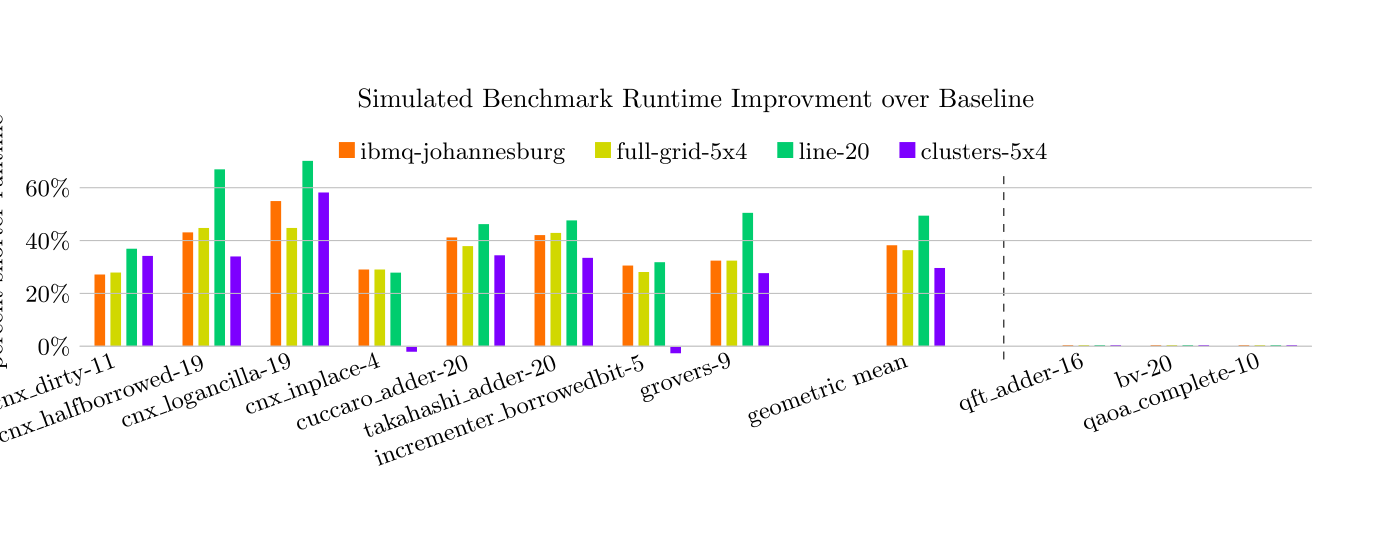

In [48]:
#interaction_modes = [
#    #("swap", :swap, "johannesburg", :swap, 0, false),
#    ("swap_one_way", :swap_one_way, "johannesburg", :swap_one_way, 0, false),
#    #("swap", :swap, "full-grid-5x4", :swap, 0, false),
#    ("swap_one_way", :swap_one_way, "full-grid-5x4", :swap_one_way, 0, false),
#    #("swap", :swap, "line-20", :swap, 0, false),
#    ("swap_one_way", :swap_one_way, "line-20", :swap_one_way, 0, false),
#    #("swap", :swap, "clusters-5x4", :swap, 0, false),
#    ("swap_one_way", :swap_one_way, "clusters-5x4", :swap_one_way, 0, false),
#]
rename_device2(dev_name) = replace(replace(replace(replace(dev_name,
    "johannesburg"=>"ibmq-johannesburg"), "xxfull-grid-5x4"=>"grid"), "xxline-20"=>"line"), "xxclusters-5x4"=>"clusters")
device_interaction_pairs2 = [
    #"comp$(comp3 ? "3" : "2") ($dev_name, $inter_name)" => (
    rename_device2(dev_name) => (
        false, dev_name, inter_mode, alt_mode, thresh, use_anc)
    for (dev_name, dev_con) in pairs(all_dev_cons)
    for (inter_name, inter_mode, dev_prefix, alt_mode, thresh, use_anc) in interaction_modes
    if startswith(dev_name, dev_prefix)
#    for comp3 in [false, true]
]
#all_shown_names = OrderedDict(
#    #(shuff ? "$kk-shuff" : "$kk") => (kk, shuff)
#    "$kk" => (kk, shuff)
#    for k in keys(benchmark_circuits)
#    if !occursin("-shuff", k) && !occursin("-compile3", k)
#    for kk in [replace(k, "-compile2" => "")]
#    for shuff in [true]
#)
#insert!(all_shown_names, length(all_shown_names)-2, "\U00A0"=>("gap", false))
#insert!(all_shown_names, length(all_shown_names)-2, raw"geometric mean"=>("geomean", false))
#insert!(all_shown_names, length(all_shown_names)-2, "\U00A0\U00A0"=>("gap", false))
dev_values = OrderedDict(
    "johannesburg"=>([], []), "full-grid-5x4"=>([], []), "line-20"=>([], []), "clusters-5x4"=>([], []))
ax = plot.BarPlot("Simulated Benchmark Runtime Improvment over Baseline",
                  ylabel="percent shorter runtime",
                  bar_width="4pt", bar_space="2pt", ygrid=true, ymax=79,
                  rotate_labels=20, y_tick_suffix=raw"\%",
                  extra_graphs="""\\addplot[draw=black,dashed,smooth] 
    coordinates {(\U00A0\U00A0,-5) (\U00A0\U00A0,65)};""")
make_bar_plot(
    #keys(benchmark_circuits),
    all_shown_names,
    #["bv-176", "bv-176-shuff",
    # "qaoa_random1-176", "qaoa_random1-176-shuff",
    # "cnx_logancilla-175", "cnx_logancilla-175-shuff",
    # "cuccaro_adder-176", "cuccaro_adder-176-shuff",
    # "takahashi_adder-176", "takahashi_adder-176-shuff"],
    #["bv-100", "cnx_logancilla-99", "cuccaro_adder-100", "takahashi_adder-100"],
    #["bv-6", "cnx_logancilla-5", "cuccaro_adder-6", "takahashi_adder-6"],
    device_interaction_pairs2,
    #["plain-17, swap" => ("plain-17", :swap)],
    label_rotation=30, label_anchor="right",
    width=0.7, gap=0.1,
    colors=colors4,
    ax=ax,
) do (bench_name, shuff), (comp3, dev_name, inter_mode, alt_mode, thresh, use_anc)
    bench_name == "gap" && return NaN
    if bench_name == "geomean"
        mean2 = 10^mean(log10.(dev_values[dev_name][1]))
        mean3 = 10^mean(log10.(dev_values[dev_name][2]))
        v = -(mean3-mean2)/mean2*100 + 0.4
        println("Geo mean for $dev_name: $v")
        return v
    end
    
    bench_name3 = bench_name * "-compile3"
    bench_name2 = bench_name * "-compile2"
    if shuff
        bench_name3 *= "-shuff"
        bench_name2 *= "-shuff"
    end
    function get_cost(bench_name)
        (c_inter, interaction_graph, dev_con, circuit_to_device_map
            ) = all_mappings["$bench_name on $dev_name"]
        c_sched = schedule_for_static_mapping(
            c_inter, dev_con, circuit_to_device_map, inter_mode,
            alt_mode, thresh, use_anc)
        #cost = schedule_cost(c_sched, model)
        cost = compact_schedule_cost(c_sched, model)
        #println("$bench_name: $(cost.num_gates2-cost.num_comm_gates2)")
        #total_success_probability(model, cost)
        cost.time
        #cost.num_gates2
        #(cost.num_gates2-cost.num_comm_gates2) / cost.num_gates2
    end
    c3 = get_cost(bench_name3)
    c2 = get_cost(bench_name2)
    push!(dev_values[dev_name][1], c2)
    push!(dev_values[dev_name][2], c3)
    -(c3-c2)/c2*100 + 0.4  # Extra to make them show up
end
#ax.legend([])
#ax.legend(loc="lower left")
#ax.set_title("Benchmarks")
#ax.set_xlabel("Benchmarks")
#ax.set_ylabel("Success Probability")
#ax.set_ylim(0, 1)
#a.set_yscale("log")

save_plot("benchmark-time-ratio.tex", ax, two_col=true, latex_height=raw"0.5*\columnwidth")

Geo mean for johannesburg: 37.17711233811081
Geo mean for full-grid-5x4: 35.949396509888224
Geo mean for line-20: 47.945364137106395
Geo mean for clusters-5x4: 26.288559342717726


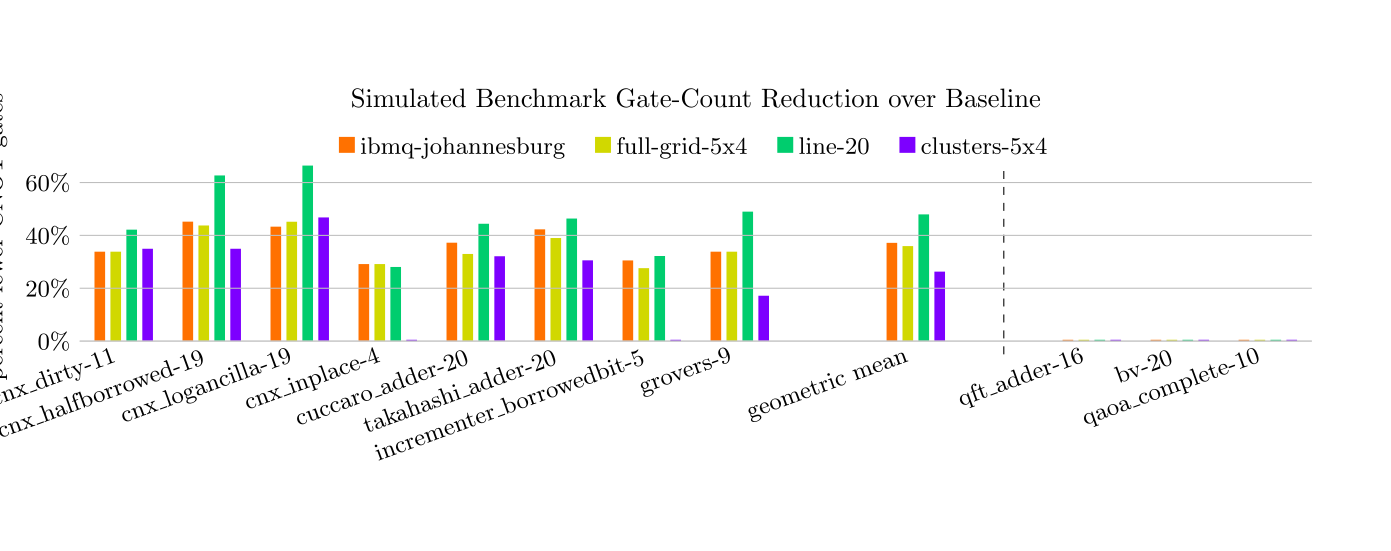

In [49]:
dev_values = OrderedDict(
    "johannesburg"=>([], []), "full-grid-5x4"=>([], []), "line-20"=>([], []), "clusters-5x4"=>([], []))
ax = plot.BarPlot("Simulated Benchmark Gate-Count Reduction over Baseline",
                  ylabel="percent fewer CNOT gates",
                  bar_width="4pt", bar_space="2pt", ygrid=true, ymax=79,
                  rotate_labels=20, y_tick_suffix=raw"\%",
                  extra_graphs="""\\addplot[draw=black,dashed,smooth] 
    coordinates {(\U00A0\U00A0,-5) (\U00A0\U00A0,65)};""")
make_bar_plot(
    #keys(benchmark_circuits),
    all_shown_names,
    #["bv-176", "bv-176-shuff",
    # "qaoa_random1-176", "qaoa_random1-176-shuff",
    # "cnx_logancilla-175", "cnx_logancilla-175-shuff",
    # "cuccaro_adder-176", "cuccaro_adder-176-shuff",
    # "takahashi_adder-176", "takahashi_adder-176-shuff"],
    #["bv-100", "cnx_logancilla-99", "cuccaro_adder-100", "takahashi_adder-100"],
    #["bv-6", "cnx_logancilla-5", "cuccaro_adder-6", "takahashi_adder-6"],
    device_interaction_pairs2,
    #["plain-17, swap" => ("plain-17", :swap)],
    label_rotation=30, label_anchor="right",
    width=0.7, gap=0.1,
    colors=
    colors=colors4,
    ax=ax,
) do (bench_name, shuff), (comp3, dev_name, inter_mode, alt_mode, thresh, use_anc)
    bench_name == "gap" && return NaN
    if bench_name == "geomean"
        mean2 = 10^mean(log10.(dev_values[dev_name][1]))
        mean3 = 10^mean(log10.(dev_values[dev_name][2]))
        v = -(mean3-mean2)/mean2*100 + 0.5
        println("Geo mean for $dev_name: $v")
        return v
    end
    
    bench_name3 = bench_name * "-compile3"
    bench_name2 = bench_name * "-compile2"
    if shuff
        bench_name3 *= "-shuff"
        bench_name2 *= "-shuff"
    end
    function get_cost(bench_name)
        (c_inter, interaction_graph, dev_con, circuit_to_device_map
            ) = all_mappings["$bench_name on $dev_name"]
        c_sched = schedule_for_static_mapping(
            c_inter, dev_con, circuit_to_device_map, inter_mode,
            alt_mode, thresh, use_anc)
        #cost = schedule_cost(c_sched, model)
        cost = compact_schedule_cost(c_sched, model)
        #total_success_probability(model, cost)
        #cost.time
        cost.num_gates2
        #(cost.num_gates2-cost.num_comm_gates2) / cost.num_gates2
    end
    c3 = get_cost(bench_name3)
    c2 = get_cost(bench_name2)
    push!(dev_values[dev_name][1], c2)
    push!(dev_values[dev_name][2], c3)
    -(c3-c2)/c2*100 + 0.5  # Extra to make them show up
end
#ax.legend([])
#ax.legend(loc="lower left")
#ax.set_title("Benchmarks")
#ax.set_xlabel("Benchmarks")
#ax.set_ylabel("Success Probability")
#ax.set_ylim(0, 1)
#a.set_yscale("log")

save_plot("benchmark-gate-ratio.tex", ax, two_col=true, latex_height=raw"0.5*\columnwidth")

Geo mean for johannesburg: 4.441252548195526
Geo mean for full-grid-5x4: 3.6940031823077475
Geo mean for line-20: 31.19060603069423
Geo mean for clusters-5x4: 2.3321217818921745


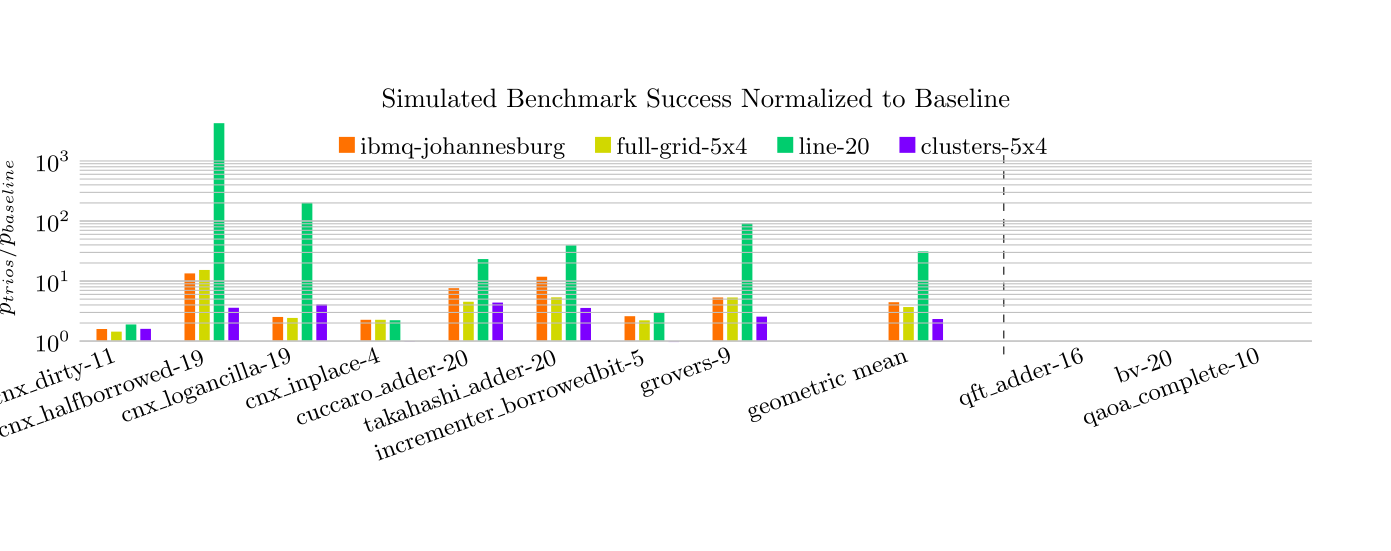

In [50]:
dev_values = OrderedDict(
    "johannesburg"=>([], []), "full-grid-5x4"=>([], []), "line-20"=>([], []), "clusters-5x4"=>([], []))
ax = plot.BarPlot("Simulated Benchmark Success Normalized to Baseline",
                  #ylabel="",
                  bar_width="4pt", bar_space="1.5pt", ygrid=true, ymin=1, ymax=2999,#4000,
                  rotate_labels=20,
                  log=true, extra_config=raw"yminorgrids=true, ylabel=$p_{trios}/p_{baseline}$",
                  extra_graphs="""\\addplot[draw=black,dashed,smooth] 
    coordinates {(\U00A0\U00A0,0.6) (\U00A0\U00A0,1500)};""")
make_bar_plot(
    #keys(benchmark_circuits),
    all_shown_names,
    #["bv-176", "bv-176-shuff",
    # "qaoa_random1-176", "qaoa_random1-176-shuff",
    # "cnx_logancilla-175", "cnx_logancilla-175-shuff",
    # "cuccaro_adder-176", "cuccaro_adder-176-shuff",
    # "takahashi_adder-176", "takahashi_adder-176-shuff"],
    #["bv-100", "cnx_logancilla-99", "cuccaro_adder-100", "takahashi_adder-100"],
    #["bv-6", "cnx_logancilla-5", "cuccaro_adder-6", "takahashi_adder-6"],
    [(is_overlay ? "X" : k)=>(is_overlay, v[2:end]...)
        for (k,v) in device_interaction_pairs2
        for is_overlay in [false]],
    #["plain-17, swap" => ("plain-17", :swap)],
    label_rotation=30, label_anchor="right",
    width=0.7, gap=0.1,
    colors=colors4,#[colors4x2; colors4x2],
    ax=ax,
) do (bench_name, shuff), (is_overlay, dev_name, inter_mode, alt_mode, thresh, use_anc)
    bench_name == "gap" && return NaN
    if bench_name == "geomean"
        mean2 = 10^mean(log10.(dev_values[dev_name][1]))
        mean3 = 10^mean(log10.(dev_values[dev_name][2]))
        v = mean3/mean2
        println("Geo mean for $dev_name: $v")
        return v
    end
    
    bench_name3 = bench_name * "-compile3"
    bench_name2 = bench_name * "-compile2"
    if shuff
        bench_name3 *= "-shuff"
        bench_name2 *= "-shuff"
    end
    function get_cost(bench_name)
        (c_inter, interaction_graph, dev_con, circuit_to_device_map
            ) = all_mappings["$bench_name on $dev_name"]
        c_sched = schedule_for_static_mapping(
            c_inter, dev_con, circuit_to_device_map, inter_mode,
            alt_mode, thresh, use_anc)
        #cost = schedule_cost(c_sched, model)
        cost = compact_schedule_cost(c_sched, model)
        total_success_probability(model, cost)
        #cost.time
        #cost.num_gates2
        #(cost.num_gates2-cost.num_comm_gates2) / cost.num_gates2
    end
    c3 = get_cost(bench_name3)
    c2 = get_cost(bench_name2)
    push!(dev_values[dev_name][1], c2)
    push!(dev_values[dev_name][2], c3)
    ###-(c3-c2)/c2*100 + 0.4  # Extra to make them show up
    
    #v = (1-(log(c3)-log(c2)) / log(c2)) * 100
    c2 == 0 && return 0
    v = c3/c2
    #println(c3)
    is_overlay ? min(v, 100) : v
end
#ax.legend([])
#ax.legend(loc="lower left")
#ax.set_title("Benchmarks")
#ax.set_xlabel("Benchmarks")
#ax.set_ylabel("Success Probability")
#ax.set_ylim(0, 1)
#a.set_yscale("log")

save_plot("benchmark-success-norm.tex", ax, two_col=true,
    latex_height=raw"0.5*\columnwidth")

Geo mean for johannesburg: 4.441252548195526
Geo mean for full-grid-5x4: 3.6940031823077475
Geo mean for line-20: 31.19060603069423
Geo mean for clusters-5x4: 2.3321217818921745


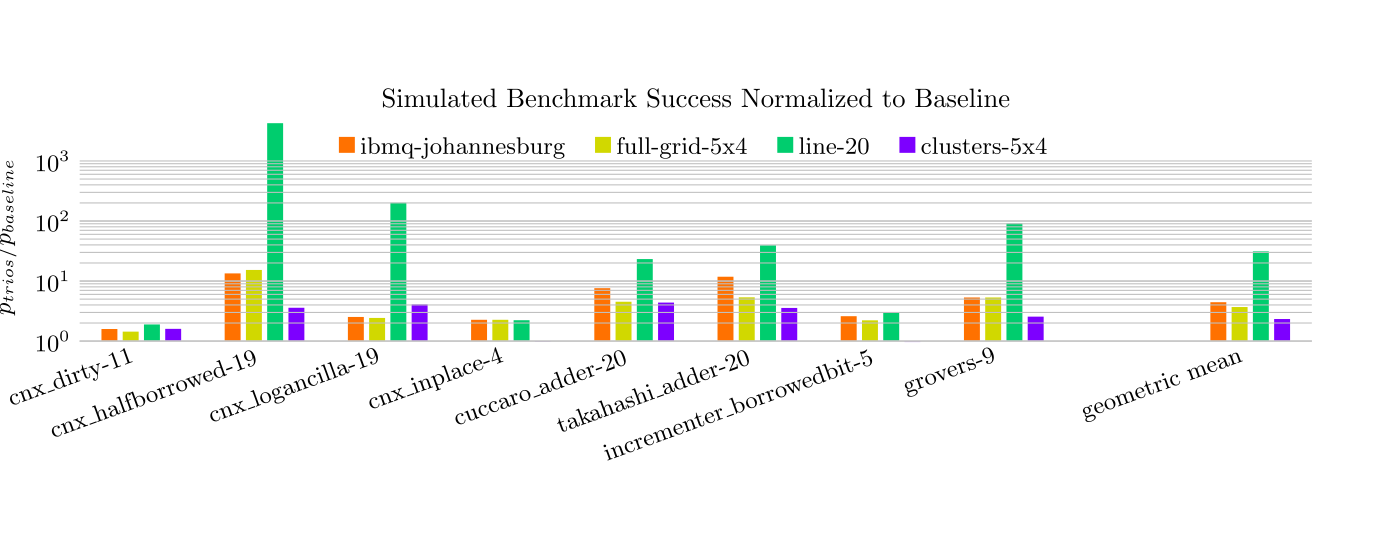

In [51]:
dev_values = OrderedDict(
    "johannesburg"=>([], []), "full-grid-5x4"=>([], []), "line-20"=>([], []), "clusters-5x4"=>([], []))
ax = plot.BarPlot("Simulated Benchmark Success Normalized to Baseline",
                  #ylabel="",
                  bar_width="6pt", bar_space="2pt", ygrid=true, ymin=1, ymax=2999,#4000,
                  rotate_labels=20,
                  log=true, extra_config=raw"yminorgrids=true, ylabel=$p_{trios}/p_{baseline}$",
                  )#extra_graphs="""\\addplot[draw=black,dashed,smooth] 
    #coordinates {(\U00A0\U00A0,0.6) (\U00A0\U00A0,1500)};""")
make_bar_plot(
    #keys(benchmark_circuits),
    all_shown_names[1:end-4],
    #["bv-176", "bv-176-shuff",
    # "qaoa_random1-176", "qaoa_random1-176-shuff",
    # "cnx_logancilla-175", "cnx_logancilla-175-shuff",
    # "cuccaro_adder-176", "cuccaro_adder-176-shuff",
    # "takahashi_adder-176", "takahashi_adder-176-shuff"],
    #["bv-100", "cnx_logancilla-99", "cuccaro_adder-100", "takahashi_adder-100"],
    #["bv-6", "cnx_logancilla-5", "cuccaro_adder-6", "takahashi_adder-6"],
    [(is_overlay ? "X" : k)=>(is_overlay, v[2:end]...)
        for (k,v) in device_interaction_pairs2
        for is_overlay in [false]],
    #["plain-17, swap" => ("plain-17", :swap)],
    label_rotation=30, label_anchor="right",
    width=0.7, gap=0.1,
    colors=colors4,#[colors4x2; colors4x2],
    ax=ax,
) do (bench_name, shuff), (is_overlay, dev_name, inter_mode, alt_mode, thresh, use_anc)
    bench_name == "gap" && return NaN
    if bench_name == "geomean"
        mean2 = 10^mean(log10.(dev_values[dev_name][1]))
        mean3 = 10^mean(log10.(dev_values[dev_name][2]))
        v = mean3/mean2
        println("Geo mean for $dev_name: $v")
        return v
    end
    
    bench_name3 = bench_name * "-compile3"
    bench_name2 = bench_name * "-compile2"
    if shuff
        bench_name3 *= "-shuff"
        bench_name2 *= "-shuff"
    end
    function get_cost(bench_name)
        (c_inter, interaction_graph, dev_con, circuit_to_device_map
            ) = all_mappings["$bench_name on $dev_name"]
        c_sched = schedule_for_static_mapping(
            c_inter, dev_con, circuit_to_device_map, inter_mode,
            alt_mode, thresh, use_anc)
        #cost = schedule_cost(c_sched, model)
        cost = compact_schedule_cost(c_sched, model)
        total_success_probability(model, cost)
        #cost.time
        #cost.num_gates2
        #(cost.num_gates2-cost.num_comm_gates2) / cost.num_gates2
    end
    c3 = get_cost(bench_name3)
    c2 = get_cost(bench_name2)
    push!(dev_values[dev_name][1], c2)
    push!(dev_values[dev_name][2], c3)
    ###-(c3-c2)/c2*100 + 0.4  # Extra to make them show up
    
    #v = (1-(log(c3)-log(c2)) / log(c2)) * 100
    c2 == 0 && return 0
    v = c3/c2
    #println(c3)
    is_overlay ? min(v, 100) : v
end
#ax.legend([])
#ax.legend(loc="lower left")
#ax.set_title("Benchmarks")
#ax.set_xlabel("Benchmarks")
#ax.set_ylabel("Success Probability")
#ax.set_ylim(0, 1)
#a.set_yscale("log")

save_plot("benchmark-success-norm-cut.tex", ax, two_col=true,
    latex_height=raw"0.5*\columnwidth")

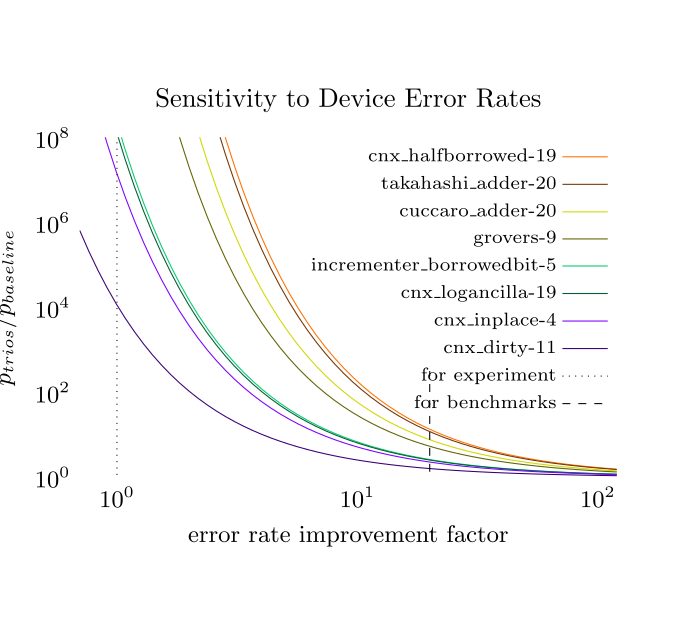

In [52]:
ax = plot.Plot("Sensitivity to Device Error Rates",
               xlabel="error rate improvement factor",
                axis="loglogaxis",
                ymax=10^8.01, ymin=0.99, xmax=120, xmin=0.7,
                hide_box=true,
                legend_pos="top-right",
                extra_config=raw"""
    ylabel=$p_{trios}/p_{baseline}$,
    legend style={
        cells={anchor=east},
        legend plot pos=right,
        draw=none,
        at={(1,1)},
        anchor=north east,
        fill=none,
        font=\small},
    clip=true""",)
bench_name = "cnx_logancilla-19"
shuff = true
dev_name = "johannesburg"
alt_mode = inter_mode = :swap_one_way
thresh = 0
use_anc = false
function model_improved_by(bf)
    ErrorModel(ibm_model,
        gate1_err=ibm_model.gate1_err/bf,
        gate2_err=ibm_model.gate2_err/bf,
        dur2_idle_err=ibm_model.dur2_idle_err/bf,
        meas_err=0,
    )
end

all_bench_names = [
    kk
    for k in keys(benchmark_circuits)
    if !occursin("-shuff", k) && !occursin("-compile3", k)
    for kk in [replace(k, "-compile2" => "")]
    if !(kk in ["qft_adder-16", "bv-20", "qaoa-complete-10"])
    for shuff in [true]
]

x_arr = 10 .^ LinRange(log10(0.7), log10(120), 60)
#x_arr = LinRange(1, 100, 30)
y_arrs = OrderedDict(bench_name=>[
    begin
        model = model_improved_by(x)
        bench_name3 = bench_name * "-compile3"
        bench_name2 = bench_name * "-compile2"
        if shuff
            bench_name3 *= "-shuff"
            bench_name2 *= "-shuff"
        end
        function get_cost(bench_name)
            (c_inter, interaction_graph, dev_con, circuit_to_device_map
                ) = all_mappings["$bench_name on $dev_name"]
            c_sched = schedule_for_static_mapping(
                c_inter, dev_con, circuit_to_device_map, inter_mode,
                alt_mode, thresh, use_anc)
            #cost = schedule_cost(c_sched, model)
            cost = compact_schedule_cost(c_sched, model)
            total_success_probability(model, cost)
            #cost.time
            #cost.num_gates2
            #(cost.num_gates2-cost.num_comm_gates2) / cost.num_gates2
        end
        c3 = get_cost(bench_name3)
        c2 = get_cost(bench_name2)
        push!(dev_values[dev_name][1], c2)
        push!(dev_values[dev_name][2], c3)
        ###-(c3-c2)/c2*100 + 0.4  # Extra to make them show up

        #v = (1-(log(c3)-log(c2)) / log(c2)) * 100
        v = c2 == 0 ? 0 : c3/c2
    end
    for x in x_arr]
    for bench_name in all_bench_names)
sort!(y_arrs, by=bname->-y_arrs[bname][1])

font = raw"\scriptsize"
for ((b_name, y_arr), color) in zip(y_arrs, colors4x2)
    ax.plot((x_arr...,), y_arr, legend="$font{$b_name}", color=color)
end
ax.plot([1, 1], [0.1, 10^30], legend="$font{for experiment}", color="black, dotted")
ax.plot([20, 20], [0.1, 10^2.5], legend="$font{for benchmarks}", color="black, dashed")
save_plot("benchmark-error-sensitivity.tex", ax, two_col=false,
    latex_height=raw"0.7*\columnwidth")